<h1>Electric properties</h1>


Run the below code to load the Hylleraas Software Platform.

In [1]:
import hylleraas as hsp
import os

school_wrk=os.path.realpath('./')+'/school_wrk'
local_env = hsp.create_compute_settings('local', work_dir=school_wrk)

water_bohr_str="""O  0.00000 0.727845024435 -0.000000000000
H -1.510000  -0.360000 -0.000000000000
H  1.510000  -0.360000  0.000000000000"""
water_bohr = hsp.Molecule(water_bohr_str)
water_bohr.units = 'bohr'
print("--- Water geometry in bohr.")
print(water_bohr.xyz_string)

water_ang = hsp.Molecule(water_bohr_str)
water_ang.units = 'angstrom'
print("--- Water geometry in ångström.")
print(water_ang.xyz_string)


--- Water geometry in bohr.
3

O 0.000000000000 0.727845024435 -0.000000000000
H -1.510000000000 -0.360000000000 -0.000000000000
H 1.510000000000 -0.360000000000 0.000000000000

--- Water geometry in ångström.
3

O 0.000000000000 0.385159000000 -0.000000000000
H -0.799057588464 -0.190503795925 -0.000000000000
H 0.799057588464 -0.190503795925 0.000000000000



<h2>Exercise 1</h2>

Properties can either be computed directly using finite field methods or indirectly using perturbation theory. The former rely on computing e.g. the energy for several different field strengths and using the resulting curve to estimate properties. The latter only needs computations at a single field strength (typically zero), and instead directly computes derivatives.

Here we shall estimate the <b>dipole moment</b> and <b>static polarizability</b> using a finite field method. We plot the energy $\mathcal{E}(E_y) = \mathcal{E}(0) - \mu_y(0)\, E_y - \frac{1}{2} \alpha_{yy} E_y^2 + ...$.

First- and second-order derivatives can be estimated using finite difference ratios,

$f'(x) \approx \frac{f(x+h) - f(x-h)}{2h}$
$f''(x) \approx \frac{f(x+h) - 2 f(x) + f(x-h)}{h^2}$

Alternatively, they can estimated by fitting a polynomial (e.g., using np.polyfit)). From a quadratic fit,

$f(x) \approx a_0 + a_1 x + a_2 x^2$

one can read off the estimates $f'(0) \approx a_1$ and $f''(0) \approx 2 a_2$.

<b>Task 1: Modify the below code snippet so that you run Orca for a few different electric fields in the y direction. As output, Orca gives you the energy and also the dipole moment. Plot the energy as a function of electric field. Estimate the derivative of the energy w.r.t. an electric field component. Does it match the corresponding dipole moment component?</b>

<b>Task 2: Also estimate the curvature (second derivative) w.r.t. electric field.</b>

<b>Task 3: Finally, plot the dipole moment $\mu_y(E_y)$ as a function of the electric field. Estimate the slope, which should be the polarizability element $\alpha_{yy}$. Does it match the estimate from the curvature?</b>

Bonus task: Using only the data you already have from the Orca runs you did for Task 1-3, can you figure out a way to estimate the entire polarizability tensor (a 3 x 3 matrix?

<b>Hint</b>: To estimate derivatives, we need to balance two aspects. The field strengths used should be small enough that higher order effects can be neglected. The field strengths should also be large enough that energy differences do suffer from too much loss of precision. For tiny field strengths, the effect on the energy might come into the 10th digit of the energy and be swamped out by numerical noise. A good order of magnitude in this exercise is $E_y \sim 0.01$ au.

<i>Remark 1: Implementations vary in whether they include the factor $-e$ (electron charge) in the reported dipole moment. Orca does not, so it really is the dipole moment to within a sign.</i>
    
<i>Remark 2: Moreover, it is important to treat the nuclear dipole moment consistently. Either (a) include the energy of the nuclei in the uniform electric field in the total energy and use the total dipole moment. Or (b) use the electronic energy and the electronic dipole moment. With Orca, the output corresponds to situation (a).)</i>

Processing: 100%|██████████| 5/5 [00:00<00:00, 75.03it/s]


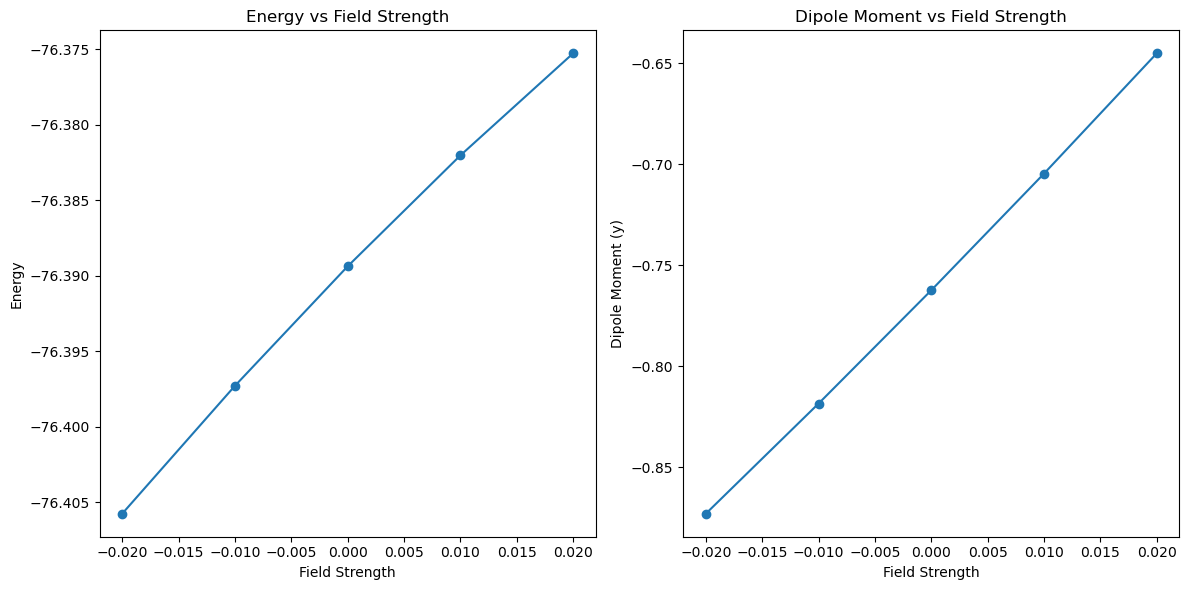

Energy(Field) =  [ -2.84430962   0.76174319 -76.38937281]
DipMom(Field) =  [ 5.6962   -0.760734]
alpha_yy =  5.688619248244343
alpha_yy =  5.696200000000002


In [3]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

energies = []
dipmom_y = []
mom_vec = []
field = []

field_range = [-0.02, -0.01, 0, 0.01, 0.02] #np.arange(-0.02, 0.02, 0.01)
for e in tqdm(field_range, desc="Processing"):
    orca_efield = hsp.Orca({'qcmethod': ['DFT', 'BLYP'], 'basis': 'pcseg-1', 
                         'scf': {'efield': f'0.0, {e}, 0.0'}}, 
                        compute_settings=local_env)
    
    result = orca_efield.run(water_bohr)
    field.append(e)
    energies.append(result['energy'])
    mom_vec.append(result['dipole_vector'])
    dipmom_y.append(result['dipole_vector'][1])

# Create figure
plt.figure(figsize=(12, 6))

# Energy plot
plt.subplot(1, 2, 1)
plt.plot(field, energies, marker='o')
plt.xlabel('Field Strength')
plt.ylabel('Energy')
plt.title('Energy vs Field Strength')

# Dipole moment plot
plt.subplot(1, 2, 2)
plt.plot(field, dipmom_y, marker='o')
plt.xlabel('Field Strength')
plt.ylabel('Dipole Moment (y)')
plt.title('Dipole Moment vs Field Strength')

plt.tight_layout()
plt.show()

Efit = np.polyfit(field,energies,2)
mufit = np.polyfit(field,dipmom_y,1)
print('Energy(Field) = ',Efit)
print('DipMom(Field) = ',mufit)
print('alpha_yy = ',-2*Efit[0])
print('alpha_yy = ',mufit[0])

<h2>Exercise 2</h2>

Having done the above finite field estimation of the dipole moment and polarizability, let us now use a perturbative approach. The electronic structure code Dalton has an extensive response theory implementation. So by running Dalton, we do not need to vary the electric field explicitly. The uniform electric field is zero in the Dalton calculation and derivatives are computed using only information from this zero-field calculation.

<b>Run the below code and note three frequency-dependent polarizabilities alpha(omega) that are reported by Dalton. Look at the 3x3 matrix corresponding to the static polarizability. Compare it the result of Exercise 1. How good is the agreement?</b>

In [ ]:
dalton = hsp.Dalton({
    'qcmethod': ['DFT', 'BLYP'], 
    'basis': 'pcseg-1', 
    'properties': {
        'energy': True, 
        'analytical_gradient': False, 
        'polarizabilities': {'frequencies': [0.07198, 0.12099]},
    }
},
    compute_settings=local_env)

result = dalton.run(water_ang)
print('Dalton DFT/BLYP/pcseg-1 results')
print(f'    Total energy: {result.energy}')
print(f'      - nuclear repulsion: {result.nuclear_repulsion_energy}')
print(f'      - electronic energy: {result.electronic_energy}')
print()
for i, freq in enumerate(result.polarizabilities.frequencies):
    polarizability_tensor = result.polarizabilities.values[i]
    print(f'---Polarizability tensor for frequency: {freq}')
    for row in polarizability_tensor:
        print(row)
    print()

<h2>Exercise 3: finite field calculations with the quasienergy</h2>

For the vast majority of quantum chemists, the quasienergy is merely a theoretical notion that helps in unifying response theory and to derive working equations for computer implementations. However, the quasienergy itself is not actually computed in a normal implementation.

Chapter 5 of the book by Norman, Ruud, Saue presents a pedagogical analysis where the quasienergy is computed within an analytical toy model with two states. Aside from that work, I am not aware of any such direct use of the quasienergy. Nonetheless, though unconventional, it should be possible to compute dynamic (frequency-dependent) properties by directly computing the quasienergy for different field strengths. After this exercise, you'll thus be part of an extremely tiny minority in the world who have done calculations with the quasienergy itself.

Strictly speaking, the quasienergy formalism relies on the assumption that all physical quantities are periodic in time. Forever, both forwards and backwards in time. This means that we cannot start the simulation at $t=0$ from the unperturbed ground state. What would be a valid initial state at $t=0$, then? One way of determining that is to slowly switch on the electric field from zero to the full periodic electric field. This is akin to how classical Molecular Dynamics simulations are equilibrated by starting in nonequilibrium and running until they are close enough to an equilibrium situation.

Below we'll run a time-dependent CI Singles code implemented within the HyQD package. In the simulation an electric field with a single frequency $\omega$ and period $T = 2\pi/\omega$ is specified by giving the frequency and the amplitude E0. The simulation slowly switches (or "ramps up") the electric field by multiplying the specified periodic field with a ramp function that is zero at $t=0$ and becomes one at $t=NT$, where the default is $N=3$ cycles. For times $t \geq NT$, everything is then hopefully periodic in time.

<b>Task 1: Run the below time-dependent CI Singles code. The example system is a hydrogen molecule and the electric field is applied along the bond axis. Examine the plotted electric field, dipole moment, and quasienergy Q(t). Does it look like the slow switching of the electric field succeeded in reaching a state with periodic time evolution?</b>

[13:12:11] WARNING: not removing hydrogen atom without neighbors


2

H 0.673052415451 0.000000000000 0.000000000000
H -0.673052415451 0.000000000000 0.000000000000

[-1.87073191 -1.87073191 -1.87073191 ... -1.87073447 -1.87073447
 -1.87073447]


/opt/conda/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'Q(t)')

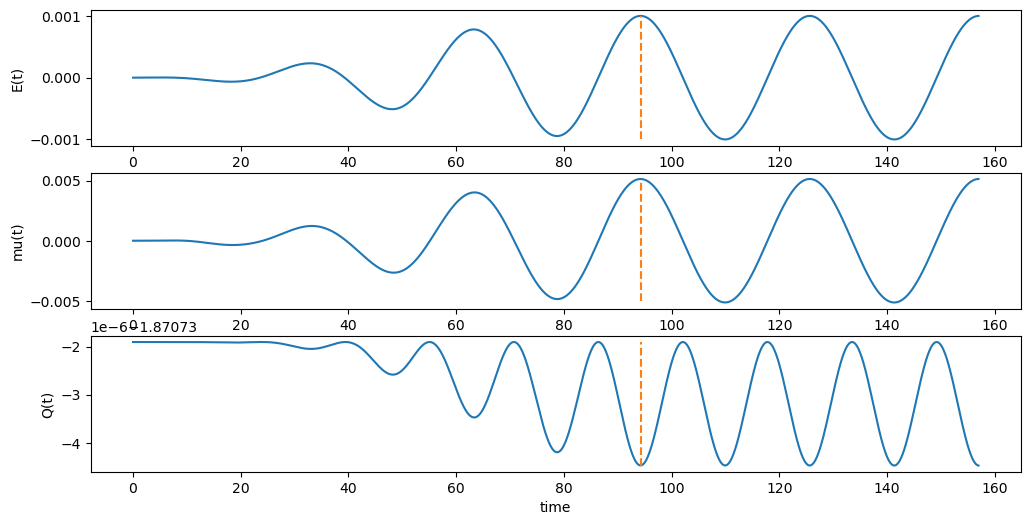

In [11]:
import hylleraas as hsp
import matplotlib.pyplot as plt

h2 = hsp.Molecule("[HH]")
h2.units = 'bohr'   # change units to bohr, because HyQD expects it
print(h2.xyz_string)

omega = 0.2

compute_settings = hsp.create_compute_settings('local')

hyqd_quasi_energy = hsp.HyQD(
    {
        "check_version": True,
        "basis": "aug-cc-pvdz",
        "method": "tdcis_quasi_energy",
        # Values for the following can be set here:
        #    E0                 (default 0.001)
        #    omega              (default 0.2)
        #    phase              (default 0.0)
        #    n_cycles_ramp      (default 3)
        #    n_cycles_post_ramp (default 1)
        #    pol_dir            (default 2)
        #    time_step          (default 0.1)
        "n_cycles_post_ramp" : 2,
        "E0": 0.001,
        "omega": omega,
        "phase": 0.0,
    }, 
#    compute_settings=compute_settings,
    compute_settings=local_env,
)

result = hyqd_quasi_energy.run(h2)

time_points = result["time_points"]
electric_field = result["electric_field"]
dipole_moment = result["dipole_moment"]
Q_t = result["Q_t"]

print(Q_t)

plt.figure(figsize=(12, 6))

# plot E(t), mu(t), Q(t)
Tperiod = 2*np.pi / omega

plt.subplot(3, 1, 1)
plt.plot(time_points, electric_field, linestyle='-')
plt.plot([3*Tperiod,3*Tperiod],[-0.001,0.001], linestyle='--')
plt.xlabel('time')
plt.ylabel('E(t)')
plt.subplot(3, 1, 2)
plt.plot(time_points, dipole_moment, linestyle='-')
plt.plot([3*Tperiod,3*Tperiod],[-0.005,0.005], linestyle='--')
plt.xlabel('time')
plt.ylabel('mu(t)')
#plt.title('time series')
plt.subplot(3, 1, 3)
plt.plot(time_points, Q_t, linestyle='-')
plt.plot([3*Tperiod,3*Tperiod],[min(Q_t),max(Q_t)], linestyle='--')
plt.xlabel('time')
plt.ylabel('Q(t)')
#plt.title('time series')

In the code block below, two building blocks are provided:

First, wrapper routine QT_and_muFourier(Ehat,omega) to the HyQD function that computes the time series of the quasienergy and the dipole moment. The <b>input</b> is a complex number corresponding to the complex Fourier component $\hat{E}(\omega)$ defining the electric field as well as the frequency $\omega$:

$E(t) = \hat{E}(\omega) \, e^{-i \omega t} + \hat{E}(-\omega) \, e^{+i \omega t}$

The wrapper routine finds the last period in the time series, and computes <b>the time average of the quasienergy</b> and the <b>Fourier components of the dipole moment</b>, which are returned as <b>output</b>.

Secondly, for internal use by QT_and_muFourier(Ehat,omega) is a function FourierFit(a_time,time,omega) that computes the Fourier components by least-squares fitting.

<i>There is no need to look at what goes on inside these functions---treat QT_and_muFourier(Ehat,omega) as a black box.</i>

<b>Task 2: Use QT_and_muFourier(Ehat,omega) to compute the quasienergy and dipole spectrum for a few different purely real values of $\hat{E}(\omega)$. Plot the $\mathcal{Q}_T$ as a function of the real part of $\hat{E}(\omega)$ (the imaginary is zero).</b>

<i>Hint: A sensible set of field strengths is, e.g. -0.005, -0.002, 0, 0.002, 0.005.</i>

<b>Task 3: Use QT_and_muFourier(Ehat,omega) to compute the quasienergy and dipole spectrum for a few different purely imaginary values of $\hat{E}(\omega)$. Plot the $\mathcal{Q}_T$ as a function of the imaginary part of $\hat{E}(\omega)$ (the real part is zero).</b>

For a function $f(z,z^*)$ of a complex parameter $z=x+iy$, the derivative is given in terms of real and imaginary parts by

$$\frac{\partial f}{\partial z} = \frac{\partial f}{\partial x} - i\frac{\partial f}{\partial y}$$
    
This is called a <i>Wirtinger derivative</i> for those who wish read more (e.g., https://en.wikipedia.org/wiki/Wirtinger_derivatives). Of the two types of second-derivatives $\partial^2 f/\partial z^2$ and $\partial^2 f/\partial z^* \partial z$, it is the latter that is relevant for us. It is given by

$$\frac{\partial^2 f}{\partial z^* \partial z} = \frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2}$$

In particular, for our quasienergy, with $a = Re(\hat{E}(\omega))$ and $b = Im(\hat{E}(\omega))$ denoting real and imaginary parts,
$$\frac{\partial^2 \mathcal{Q}_T}{\partial \hat{E}(\omega)^* \partial \hat{E}(\omega)} = \frac{\partial^2 \mathcal{Q}_T}{\partial a^2} + \frac{\partial^2 \mathcal{Q}_T}{\partial b^2}$$

<b>Task 4: Estimate the above second-order quasienergy derivative. This is directly related to the polarizability $\alpha(-\omega;\omega)$.</b>

<b>Task 5: The runs that produced your two series of quasienergy also produced the Fourier coefficients of the dipole moment. Plot the real and imaginary part of dipole moment Fourier coefficient $\hat{\mu}(\omega)$ as a function a purely real $\hat{E}(\omega)$. Do the same for a purely imaginary $\hat{E}(\omega)$. Is the derivative of the dipole moment consistent with the second-derivative of the quasienergy?</b>

Hint 1: The function QT_and_muFourier(Ehat,omega) returns a list of coefficients for five frequencies: $2\omega, \omega, 0, -\omega, -2\omega$. So the first element is for the double of the frequency of the perturbation. The second element is for the same frequency as the perturbation. Extract this from the output (return value) of QT_and_muFourier(Ehat,omega).

Hint 2: Write $\hat{\mu}(\omega) = \hat{\mu}^R + i\hat{\mu}^I$ and $\hat{E}(\omega) = a + ib$. Then

$$\frac{\partial \hat{\mu}(\omega)}{\partial \hat{E}(\omega)} = \frac{\partial \hat{\mu}^R}{\partial a} + i \frac{\partial \hat{\mu}^I}{\partial a} - i \left( \frac{\partial \hat{\mu}^R}{\partial b} + i\frac{\partial \hat{\mu}^I}{\partial b} \right)$$

So these four terms need to be estimated.

Processing: 100%|██████████| 5/5 [03:19<00:00, 39.98s/it]


[-0.005, -0.002, 0, 0.002, 0.005]
[-1.870764000695296, -1.8707370405311605, -1.8707319054429976, -1.8707370405311605, -1.8707640006952955]
[-0.005, -0.002, 0, 0.002, 0.005]
[-1.870764000695296, -1.8707370405311605, -1.8707319054429976, -1.8707370405311605, -1.8707640006952955]
alpha (from Q_T) =  2.567627779111364 , alpha_R =  1.283813889555682 , alpha_I =  1.283813889555682
alpha (from mu) =  (5.136193228707537-0.00015405008767317428j) , alpha_derR =  (2.5679401820919256-0.0001623687950947116j) , alpha_derI =  (2.5682530466156113+8.318707421537308e-06j)


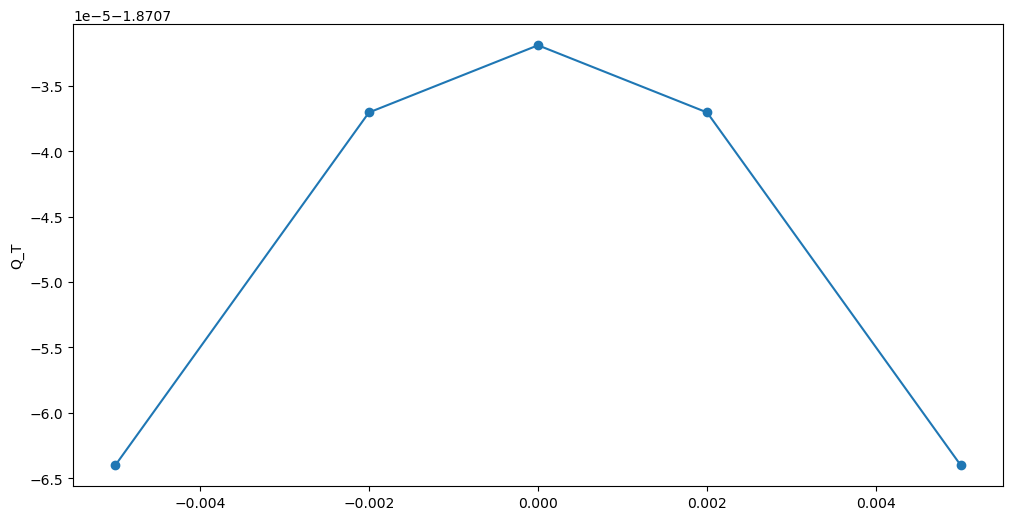

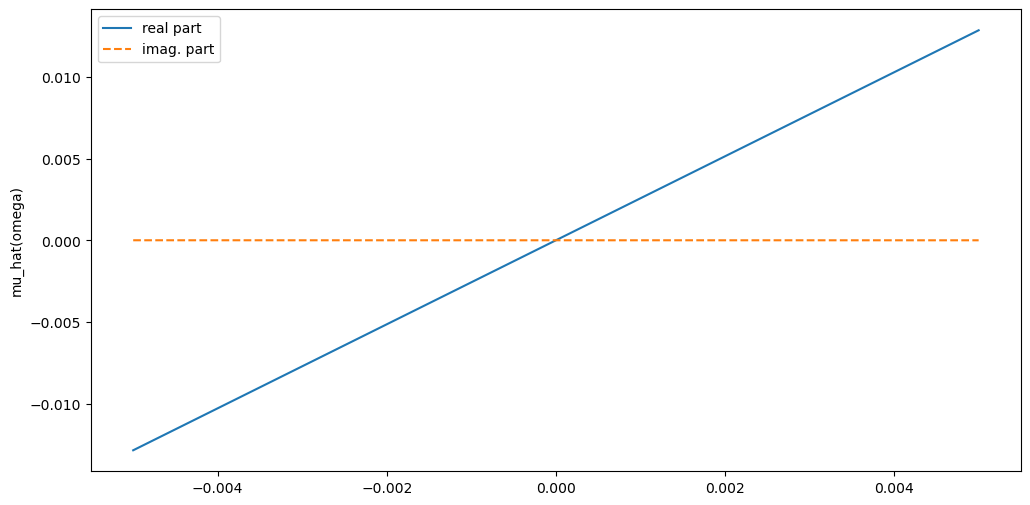

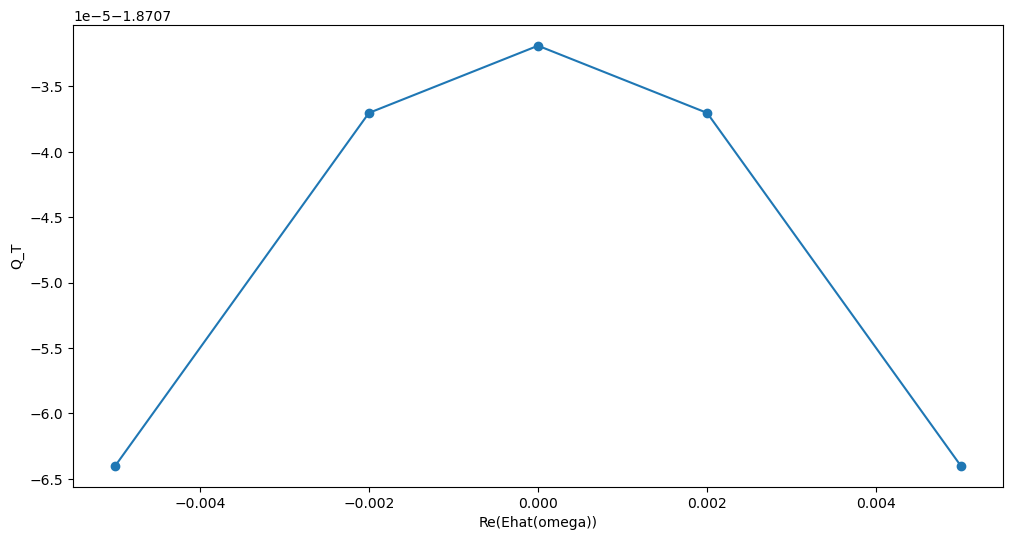

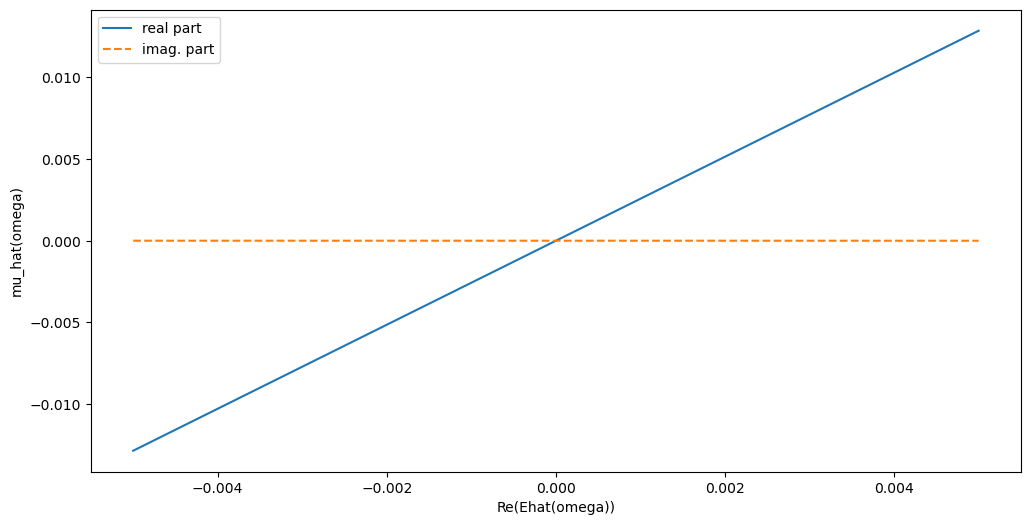

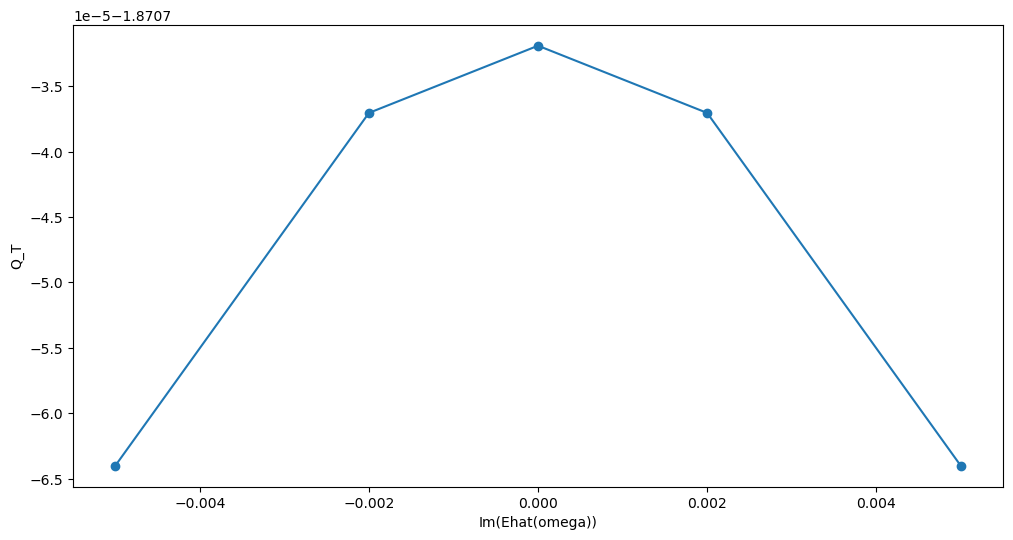

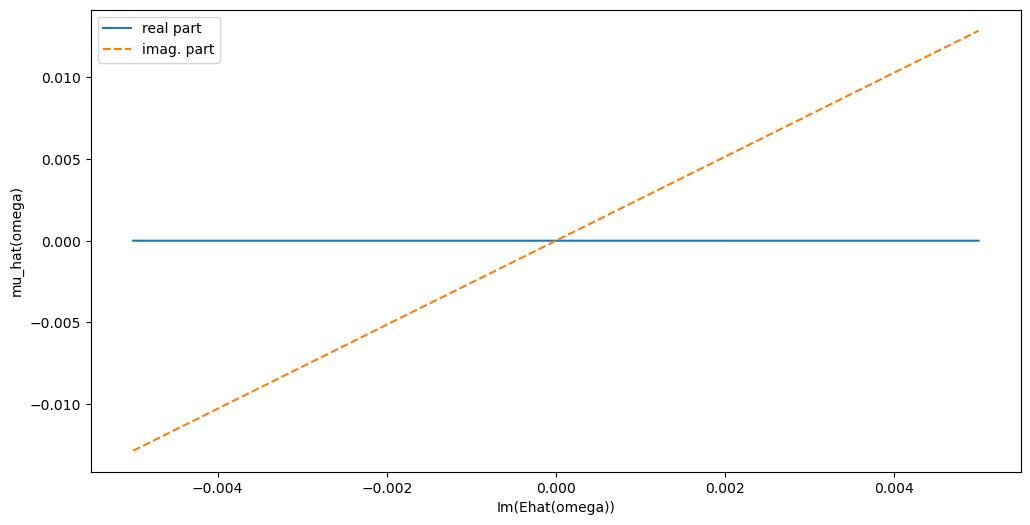

In [15]:
import hylleraas as hsp
import numpy as np
import matplotlib.pyplot as plt

def FourierFit(a_time,time,omega):
    # let us solve the equation system
    #
    # a_time(t) = \sum_k exp(-i t omega(k)) a_freq(k)
    #
    # by viewing it as a linear equation system. Define the
    # matrix M(m,k) = exp(-i time[m] * omega[k]). Then
    #
    # a_time = M a_freq   =>   M^+ a_time = M^+ M a_freq
    # =>     a_freq = (M^+ M)^-1 M a_time
    # is the least-squares solution.
    M = np.zeros((len(a_time), len(omega)), dtype=complex)
    for row in range(len(a_time)):
        for col in range(len(omega)):
            M[row,col] = np.exp(-1j * time[row] * omega[col])
    MdagM = M.conj().T @ M + 1e-8 * np.eye(len(omega))
    RHS = M.conj().T @ a_time
    a_freq = np.linalg.solve(MdagM, RHS)
    return a_freq

def QT_and_muFourier(Ehat,omega):
    # Ehat, omega specify a field in the time domain through
    #
    # E(t) = Ehat exp(-i omega t) + Ehat^* exp(i omega t)
    #
    # Writing Ehat = a + ib, we get
    #
    # E(t) = 2sqrt(a^2+b^2) (cos(omega t) a/sqrt(a^2+b^2) + sin(omega t) b/sqrt(a^2+b^2)
    #      = 2 sqrt(a^2+b^2) cos(omega t - phi)
    #
    # where phi = np.arctan2(b,a) = np.angle(Ehat)
    # For HyQD, the input is not Ehat, but
    # 1) E0 = 2 sqrt(a^2+b^2) = 2 np.abs(Ehat), and
    # 2) phase = -phi.
    
    compute_settings = hsp.create_compute_settings('local')
    hyqd_quasi_energy = hsp.HyQD(
        {
        "check_version": True,
        "basis": "aug-cc-pvdz",
        "method": "tdcis_quasi_energy",
        # Values for the following can be set here:
        #    E0                 (default 0.001)
        #    omega              (default 0.2)
        #    phase              (default 0.0)
        #    n_cycles_ramp      (default 3)
        #    n_cycles_post_ramp (default 1)
        #    pol_dir            (default 2)
        #    time_step          (default 0.1)
        "n_cycles_post_ramp" : 2,
        "E0": np.abs(Ehat),          # obs! obs! obs!
        "omega": omega,
        "phase": -np.angle(Ehat),
        }, 
    #    compute_settings=compute_settings,
    compute_settings=local_env,
    )

    result = hyqd_quasi_energy.run(h2)

    time_points = result["time_points"]
    electric_field = result["electric_field"]
    dipole_moment = result["dipole_moment"]
    Q_t = result["Q_t"]
    
    Tperiod = 2*np.pi / omega
    Tend = time_points[-1]
    Tstart = Tend - Tperiod
    kstart = max([k for k in range(len(time_points)) if time_points[k] < Tstart])
    Qhat = FourierFit(Q_t[kstart:], time_points[kstart:], [2*omega,omega,0,-omega,-2*omega])
    muhat = FourierFit(dipole_moment[kstart:], time_points[kstart:], [2*omega,omega,0,-omega,-2*omega])
    Q_time_average = Qhat[2].real

    # visual check of fitting
    #dipmom2 = muhat[0]*np.exp(-1j*2*omega*time_points)
    #dipmom2 += muhat[1]*np.exp(-1j*1*omega*time_points)
    #dipmom2 += muhat[2]
    #dipmom2 += muhat[3]*np.exp(+1j*1*omega*time_points)
    #dipmom2 += muhat[4]*np.exp(+1j*2*omega*time_points)
    #plt.figure(figsize=(12, 6))
    #plt.plot(time_points, dipole_moment, linestyle='solid')
    #plt.plot(time_points, np.real(dipmom2), linestyle='dashed')
    
    return Q_time_average, muhat
    
####################
#Q_T, mu_hat = QT_and_muFourier(0.001, 0.2)
#print('resulting Q_T = ',Q_T)
#print('resulting mu_hat = ',mu_hat)

omega_ff = 0.2
Elist = [-0.005, -0.002, 0, 0.002, 0.005]
Q_Tlist = []
muhat_list = []
for Ehat in tqdm(Elist, desc="Processing"):
    Q_T, mu_hat = QT_and_muFourier(Ehat, omega_ff)
    Q_Tlist.append(Q_T)
    muhat_list.append(mu_hat[1])

Q_Tlist_im = []
muhat_list_im = []
for Ehat in tqdm(Elist, desc="Processing"):
    Q_T, mu_hat = QT_and_muFourier(Ehat*1j, omega_ff)
    Q_Tlist_im.append(Q_T)
    muhat_list_im.append(mu_hat[1])

print(Elist)
print(Q_Tlist)
# quasienergy vs. real Fourier coefficient
plt.figure(figsize=(12, 6))
plt.plot(Elist, Q_Tlist, marker='o')
plt.ylabel('Q_T')

plt.figure(figsize=(12, 6))
plt.plot(Elist, [z.real for z in muhat_list], linestyle='solid', label='real part')
plt.plot(Elist, [z.imag for z in muhat_list], linestyle='dashed', label='imag. part')
plt.ylabel('mu_hat(omega)')
plt.legend()
    
print(Elist)
print(Q_Tlist)

# quasienergy vs. real Fourier coefficient
plt.figure(figsize=(12, 6))
plt.plot(Elist, Q_Tlist, marker='o')
plt.ylabel('Q_T')
plt.xlabel('Re(Ehat(omega))')

plt.figure(figsize=(12, 6))
plt.plot(Elist, [z.real for z in muhat_list], linestyle='solid', label='real part')
plt.plot(Elist, [z.imag for z in muhat_list], linestyle='dashed', label='imag. part')
plt.ylabel('mu_hat(omega)')
plt.xlabel('Re(Ehat(omega))')
plt.legend()

# quasienergy vs. imaginary Fourier coefficient
plt.figure(figsize=(12, 6))
plt.plot(Elist, Q_Tlist_im, marker='o')
plt.ylabel('Q_T')
plt.xlabel('Im(Ehat(omega))')

plt.figure(figsize=(12, 6))
plt.plot(Elist, [z.real for z in muhat_list_im], linestyle='solid', label='real part')
plt.plot(Elist, [z.imag for z in muhat_list_im], linestyle='dashed', label='imag. part')
plt.ylabel('mu_hat(omega)')
plt.xlabel('Im(Ehat(omega))')
plt.legend()


QTfit_R = np.polyfit(Elist,Q_Tlist,2)
QTfit_I = np.polyfit(Elist,Q_Tlist,2)
alpha_R = -2*QTfit_R[0]
alpha_I = -2*QTfit_I[0]
print('alpha (from Q_T) = ',alpha_R+alpha_I,', alpha_R = ',alpha_R,', alpha_I = ',alpha_I)

muR_fit_R = np.polyfit(Elist,[z.real for z in muhat_list],1)
muI_fit_R = np.polyfit(Elist,[z.imag for z in muhat_list],1)
muR_fit_I = np.polyfit(Elist,[z.real for z in muhat_list_im],1)
muI_fit_I = np.polyfit(Elist,[z.imag for z in muhat_list_im],1)
alpha1 = muR_fit_R[0] + 1j*muI_fit_R[0]
alpha2 = -1j*(muR_fit_I[0] + 1j*muI_fit_I[0])
print('alpha (from mu) = ',alpha1+alpha2,', alpha_derR = ',alpha1,', alpha_derI = ',alpha2)